In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import dataframe_image as dfi

### Примеры входных данных

In [3]:
# пример кода для запуска генератора данных
from data_generator.data_generator import generate_data

N = 5
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21
seed = 19
data = generate_data(N, bounds_params, grid_size, seed)

In [4]:
# Пример данных для NLP постановки
# plu_line - код продуктовой линейки
# plu - код товара
# plu_idx - индекс товара
# P - текущая цена
# Q - текущие продажи в штуках
# E - эластичность
# PC - цена конкурента/рыночная цена
# C - себестоимость товара
# x_lower - нижняя граница x для диапазона поиска цены
# x_upper - верхняя граница x для диапазона поиска цены
# x_init - начальное значение x для старта оптимизатора
data['data_nlp']
# dfi.export(data['data_nlp'], './images/data_nlp_sample.png')

,plu_line_idx,P,Q,E,PC,C,plu_idx,x_lower,x_upper,x_init
0,0,141.99,0.478022,-2.455034,138.99,104.11,0,0.900000,1.100000,1.000000
1,1,115.99,3.359042,-0.665581,112.99,87.67,1,0.900000,1.100000,1.000000
2,1,115.99,3.359042,-0.366413,112.99,87.67,2,0.900000,1.100000,1.000000
3,2,99.99,0.781950,-1.431336,91.99,73.00,3,0.900000,1.057991,0.978995
4,3,51.99,3.604018,-0.841617,50.99,39.53,4,0.900000,1.100000,1.000000
5,4,89.99,3.906002,-0.432880,97.99,120.56,5,0.925564,1.100000,1.012782


In [5]:
# Пример данных для MILP постановки
# plu_line - код продуктовой линейки
# P - текущая цена
# PC - цена конкурента/рыночная цена
# C - себестоимость товара
# Ps - сетка цен для поиска
# Qs - сетка продаж для кажой цены из Ps
# xs - сетка индексов
# grid_size - размер сетки
# P_idx - индекс текущей цены в сетке. Если значение -1, то текщая цена не попала в сетку
data['data_milp']
# dfi.export(data['data_milp'], './images/data_milp_sample.png')

,plu_line_idx,P,PC,C,Ps,Qs,xs,grid_size,P_idx,n_plu
0,0,141.99,138.99,104.11,"[127.99, 128.99, 130.99, 131.99, 132.99, 134.9...","[0.6089394539338445, 0.5985012724198178, 0.578...","[0.9014015071483906, 0.9084442566377914, 0.922...",21,10,1
1,1,115.99,112.99,87.67,"[103.99, 105.99, 106.99, 107.99, 108.99, 109.9...","[7.08731316001623, 7.0242781667422545, 6.99298...","[0.8965428054142598, 0.9137856711785499, 0.922...",21,10,2
2,2,99.99,91.99,73.00,"[89.99, 90.99, 91.99, 92.99, 93.99, 94.99, 95....","[0.9022928650366684, 0.889468741538329, 0.8768...","[0.8999899989999, 0.90999099909991, 0.91999199...",17,10,1
3,3,51.99,50.99,39.53,"[46.99, 47.99, 48.99, 49.99, 50.99, 51.99, 52....","[3.9078585400206394, 3.8451071816875837, 3.783...","[0.9038276591652241, 0.9230621273321793, 0.942...",11,5,1
4,4,89.99,97.99,120.56,"[82.99, 83.99, 84.99, 85.99, 86.99, 87.99, 88....","[4.039764869374558, 4.020379024402288, 4.00108...","[0.9222135792865874, 0.9333259251027892, 0.944...",17,7,1


### Отчет по времени работы и количеству "успешно" решенных задач

In [247]:
from runner import optimizers_collect_stat

In [248]:
stats_df = optimizers_collect_stat('./data/stat/')

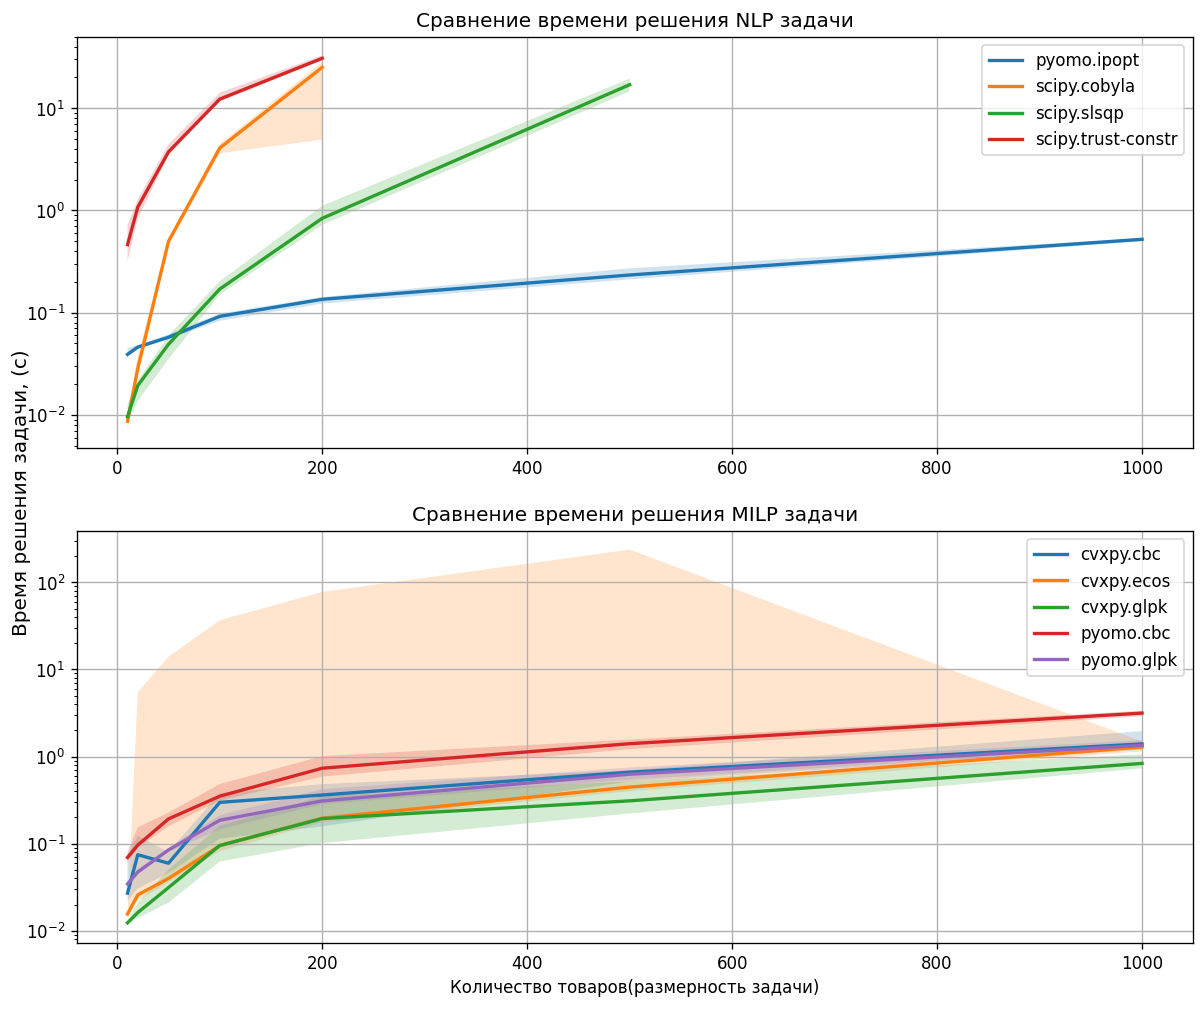

In [249]:
stats_df['success'] = stats_df['status'] == 'ok'
stats_df['opt_type'] = np.where(
    stats_df['solver'].isin(['scipy.slsqp', 'scipy.trust-constr', 'scipy.cobyla' ,'pyomo.ipopt']), 'nlp', 'lp'
)
time_rep_df = stats_df.groupby(['opt_type', 'solver', 'N'])['t'].describe().reset_index()

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharey=False, dpi=120)
for (pr_type, solver), df in time_rep_df.groupby(['opt_type', 'solver']):
    ax_id = 0 if pr_type == 'nlp' else 1
    axes[ax_id].plot(df['N'], df['50%'], lw=2, label=solver)
    axes[ax_id].fill_between(df['N'], df['25%'], df['75%'], alpha=0.2)
axes[0].set_title('Сравнение времени решения NLP задачи')
axes[1].set_title('Сравнение времени решения MILP задачи')
# [ax.set_xscale('log') for ax in axes]
[ax.set_yscale('log') for ax in axes]
[ax.legend(loc='upper right') for ax in axes]
[ax.grid() for ax in axes]
fig.text(0.08, 0.5, 'Время решения задачи, (с)', va='center', rotation='vertical', fontdict={'size': 12})
plt.xlabel('Количество товаров(размерность задачи)')
plt.savefig('./images/time_solve_compare.png')
plt.show()


In [250]:
success_rate_df =\
    stats_df.groupby(['solver'])['success'].mean().reset_index().rename(columns={'success': 'success_rate'})
success_rate_df
# dfi.export(success_rate_df, './images/success_rate.png')

,solver,success_rate
0,cvxpy.cbc,1.000000
1,cvxpy.ecos,0.714286
2,cvxpy.glpk,1.000000
3,pyomo.cbc,1.000000
4,pyomo.glpk,1.000000
5,pyomo.ipopt,1.000000
6,scipy.cobyla,0.488000
7,scipy.slsqp,0.920000
8,scipy.trust-constr,0.704000


### Пример запуска оптимизации(простой)

In [79]:
import numpy as np
from data_generator.data_generator import generate_data, price_round
from optimizers.optimization import pricing_optimization
from optimizers.optimizers import (
    ScipyNlpOptimizationModel,
    PyomoNlpOptimizationModel,
    PyomoLpOptimizationModel,
    CvxpyLpOptimizationModel,
)


def calc_metrics(df, tp='cur'):
    sfx = ''
    if tp == 'cur':
        sfx = ''
    elif tp == 'opt':
        sfx = '_opt'
    R_ = sum(df['P' + sfx] * df['Q' + sfx])
    M_ = sum((df['P' + sfx] - df['C']) * df['Q' + sfx])
    return R_, M_


def perc_delta(v_old, v_new, ndigits=2):
    p = round(100. * (v_new / v_old - 1.), ndigits)
    sign = '+' if p >= 0 else '-'
    return sign + str(abs(p)) + '%'


bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21
#
data = generate_data(50, bounds_params, grid_size, 0)
# текущая выручка и маржа
R_cur, M_cur = calc_metrics(data['data_nlp'], 'cur')
# параметры для оптимизации
opt_params = {
    'alpha': 0.0,
    'con_mrg': M_cur,
}


"""
Тест расчёта на небольших данных
"""

res_nlp, _ = pricing_optimization(data, PyomoNlpOptimizationModel, opt_params, 'ipopt')
res_milp, _ = pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')

R_opt_nlp, M_opt_nlp = calc_metrics(res_nlp['data'], 'opt')
R_opt_milp, M_opt_milp = calc_metrics(res_milp['data'], 'opt')

print('dR = {dR}, dM = {dM} - Изменение выручки и маржи в NLP задаче'.format(
    dR=perc_delta(R_cur, R_opt_nlp), dM=perc_delta(M_cur, M_opt_nlp)))
print('dR = {dR}, dM = {dM} - Изменение выручки и маржи в MILP задаче'.format(
    dR=perc_delta(R_cur, R_opt_milp),
    dM=perc_delta(M_cur, M_opt_milp)))

res_nlp['data']['P_opt'] = price_round(res_nlp['data']['P_opt'])
res_nlp['data']['x_opt'] = res_nlp['data']['P_opt'] / res_nlp['data']['P']
res_nlp['data']['Q_opt'] = res_nlp['data']['Q'] * np.exp(res_nlp['data']['E'] * (res_nlp['data']['x_opt'] - 1))
R_opt_nlp_ar, M_opt_nlp_ar = calc_metrics(res_nlp['data'], 'opt')

print('dR = {dR}, dM = {dM} - Изменение выручки и маржи в NLP задаче после округления'.format(
    dR=perc_delta(R_cur, R_opt_nlp_ar), dM=perc_delta(M_cur, M_opt_nlp_ar)))

ind = res_nlp['data'].groupby(['plu_line_idx'])['x_opt'].nunique().max() == 1
print(f'Все товары в линейке имеют одинаковые цены: {ind}')


dR = +7.9%, dM = +0.0% - Изменение выручки и маржи в NLP задаче
dR = +7.87%, dM = +0.01% - Изменение выручки и маржи в MILP задаче
dR = +7.86%, dM = +0.62% - Изменение выручки и маржи в NLP задаче после округления
Все товары в линейке имеют одинаковые цены: True


### Пример запуска оптимизации(сложный)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from data_generator.data_generator import generate_data
from optimizers.optimization import pricing_optimization
from optimizers.optimizers import (
    ScipyNlpOptimizationModel,
    PyomoNlpOptimizationModel,
    PyomoLpOptimizationModel,
    CvxpyLpOptimizationModel,
)

In [24]:
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21

data = generate_data(100, bounds_params, 21, 4)
M_cur = sum(data['data_nlp']['Q'] * (data['data_nlp']['P'] - data['data_nlp']['C']))
R_cur = sum(data['data_nlp']['Q'] * data['data_nlp']['P'])

opt_params = {
    'alpha': 0.0,
#     'con_mrg': M_cur,
    'con_equal': True
}

opt_params['alpha'] = 0.0
res, t =  pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
M_opt_min = sum((res['data']['P_opt'] - res['data']['C']) * res['data']['Q_opt'])

opt_params['alpha'] = 1.0
res, t =  pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
M_opt_max = sum((res['data']['P_opt'] - res['data']['C']) * res['data']['Q_opt'])

N_grid = 30
M_grid = np.linspace(M_opt_min, M_opt_max, N_grid)
R_norm_res = np.zeros(N_grid)
M_norm_res = np.zeros(N_grid)
R_res = np.zeros(N_grid)
M_res = np.zeros(N_grid)


opt_params['alpha'] = 0.0
for i, M in enumerate(M_grid):
    opt_params['con_mrg'] = M
    res, t = pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
    R_norm_res[i] = sum(res['data']['P_opt']  * res['data']['Q_opt']) / R_cur
    M_norm_res[i] = sum((res['data']['P_opt'] - res['data']['C'])  * res['data']['Q_opt']) / M_cur

    R_res[i] = sum(res['data']['P_opt']  * res['data']['Q_opt'])
    M_res[i] = sum((res['data']['P_opt'] - res['data']['C'])  * res['data']['Q_opt'])
    

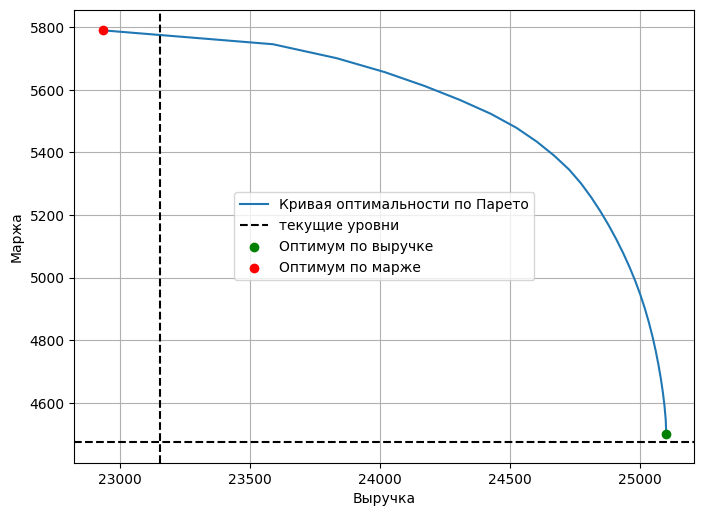

In [25]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(R_res, M_res, label='Кривая оптимальности по Парето')
plt.axvline(R_cur, ls='--', c='k', label='текущие уровни')
plt.axhline(M_cur, ls='--', c='k')
plt.scatter(R_res[0], M_res[0], c='g', label='Оптимум по выручке', zorder=2)
plt.scatter(R_res[-1], M_res[-1], c='r', label='Оптимум по марже', zorder=2)
plt.xlabel('Выручка')
plt.ylabel('Маржа')
plt.grid()
plt.legend()
plt.show()

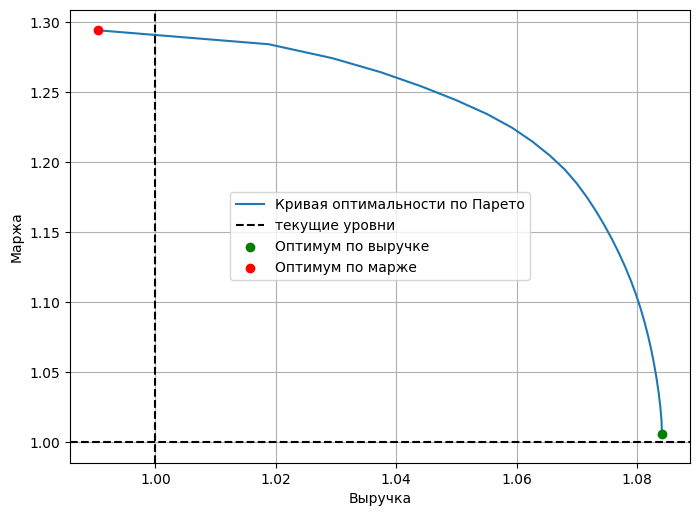

In [26]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(R_norm_res, M_norm_res, label='Кривая оптимальности по Парето')
plt.axvline(1, ls='--', c='k', label='текущие уровни')
plt.axhline(1, ls='--', c='k')
plt.scatter(R_norm_res[0], M_norm_res[0], c='g', label='Оптимум по выручке', zorder=2)
plt.scatter(R_norm_res[-1], M_norm_res[-1], c='r', label='Оптимум по марже', zorder=2)
plt.xlabel('Выручка')
plt.ylabel('Маржа')
plt.grid()
plt.legend()
plt.show()

### Проверка на прочность  при решении ~100000 товаров

### Запус MINLP с pyomo

In [180]:
from data_generator.data_generator import generate_data
from optimizers.optimization import pricing_optimization
from optimizers.optimizers import PyomoNlpOptimizationModel
from itertools import product

SEED_GRID = list(range(3))
N_GRID = list(range(5, 30, 5))
GRID = product(N_GRID, SEED_GRID)

bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
GRID_SIZE = 21
GRID = product(N_GRID, SEED_GRID)
minlp_stats_df_list = []

for N, seed in GRID:
    print(N, seed)
    data = generate_data(N, bounds_params, GRID_SIZE, seed)
    N_plu = len(data['data_nlp'])
    # текущая выручка и маржа
    R_cur, M_cur = calc_metrics(data['data_nlp'], 'cur')
    # параметры для оптимизации
    opt_params = {
        'alpha': 0.0,
        'con_mrg': M_cur,
        'con_chg_cnt':  int(0.7 * N_plu)
    }
    res_minlp, t_minlp = pricing_optimization(data, PyomoNlpOptimizationModel, opt_params, 'bonmin')
    minlp_stats_df_list.append(pd.DataFrame({
        'N': [N],
        'seed': [seed],
        't': [t_minlp],
        'status': [res_minlp['status']]
    }))
    
    print('minlp finished at %.3f' % t_minlp)
    print('---*---*---*---*---*---*---*---*---*---*---*---*---*---*---')
minlp_stats_df = pd.concat(minlp_stats_df_list)

minlp_stats_df.to_csv('./data/stat_minlp/stat.csv', index=None)

5 0
minlp finished at 0.354
---*---*---*---*---*---*---*---*---*---*---*---*---*---*---
5 1
minlp finished at 1.453
---*---*---*---*---*---*---*---*---*---*---*---*---*---*---
5 2
minlp finished at 0.279
---*---*---*---*---*---*---*---*---*---*---*---*---*---*---
10 0
minlp finished at 1.896
---*---*---*---*---*---*---*---*---*---*---*---*---*---*---
10 1
minlp finished at 1.842
---*---*---*---*---*---*---*---*---*---*---*---*---*---*---
10 2
minlp finished at 1.286
---*---*---*---*---*---*---*---*---*---*---*---*---*---*---
15 0
minlp finished at 5.599
---*---*---*---*---*---*---*---*---*---*---*---*---*---*---
15 1
minlp finished at 1.394
---*---*---*---*---*---*---*---*---*---*---*---*---*---*---
15 2
minlp finished at 1.674
---*---*---*---*---*---*---*---*---*---*---*---*---*---*---
20 0
minlp finished at 6.339
---*---*---*---*---*---*---*---*---*---*---*---*---*---*---
20 1
minlp finished at 10.323
---*---*---*---*---*---*---*---*---*---*---*---*---*---*---
20 2
minlp finished at 

FileNotFoundError: [Errno 2] No such file or directory: './data/minlp_stats/stats.csv'

In [185]:
minlp_stats_df = pd.read_csv('./data/stat_minlp/stat.csv')

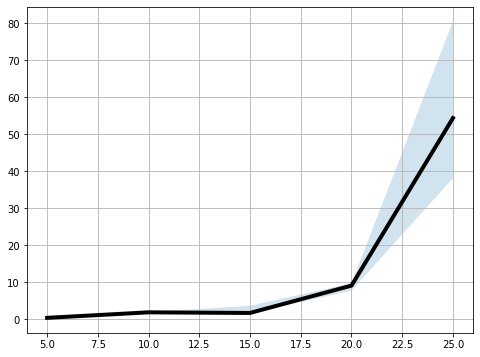

In [232]:
time_rep_df = minlp_stats_df.groupby(['N'])['t'].describe().reset_index()
plt.figure(figsize=(8, 6))
plt.plot(time_rep_df['N'], time_rep_df['50%'], c='k', lw=4)
plt.fill_between(time_rep_df['N'], time_rep_df['25%'], time_rep_df['75%'], alpha=0.2)
plt.grid()
plt.show()

### Сравнение решений оптимизаторов

In [209]:
%%time
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21


data = generate_data(50, bounds_params, 21,)
M_cur = sum(data['data_nlp']['Q'] * (data['data_nlp']['P'] - data['data_nlp']['C']))
R_cur = sum(data['data_nlp']['Q'] * data['data_nlp']['P'])

opt_params = {
    'alpha': 0.0,
    'con_mrg': M_cur
}

data['data_milp']


CPU times: user 73.9 ms, sys: 3.13 ms, total: 77 ms
Wall time: 76.3 ms


,plu_line_idx,P,PC,C,Ps,Qs,xs,grid_size,P_idx,n_plu
0,0,62.99,59.99,49.33,"[56.99, 57.99, 58.99, 59.99, 60.99, 61.99, 62....","[2.961582815855361, 2.892312488720968, 2.82466...","[0.9047467852040006, 0.9206223210033339, 0.936...",13,6,1
1,1,106.99,107.99,81.54,"[95.99, 96.99, 97.99, 99.99, 100.99, 101.99, 1...","[2.269258692946399, 2.2637988544013967, 2.2583...","[0.8971866529582204, 0.9065333208711095, 0.915...",21,10,1
2,2,88.99,88.99,71.66,"[79.99, 80.99, 81.99, 82.99, 83.99, 84.99, 85....","[0.9561916210850114, 0.9478413993860582, 0.939...","[0.8988650410158445, 0.9101022586807507, 0.921...",19,9,1
3,3,108.99,106.99,90.75,"[97.99, 98.99, 99.99, 100.99, 101.99, 103.99, ...","[3.0685865296883006, 3.0477476004666686, 3.027...","[0.8990733094779337, 0.908248463161758, 0.9174...",21,10,1
4,4,68.99,68.99,56.25,"[61.99, 62.99, 63.99, 64.99, 65.99, 66.99, 67....","[2.4600286962304545, 2.3993955431805185, 2.340...","[0.898536019713002, 0.913030874039716, 0.92752...",15,7,1
5,5,76.99,75.99,73.02,"[68.99, 69.99, 70.99, 71.99, 72.99, 73.99, 74....","[5.549966654286842, 5.5233231783514976, 5.4968...","[0.8960904013508247, 0.9090791011819717, 0.922...",17,8,1
6,6,64.99,59.99,48.64,"[58.99, 59.99, 60.99, 61.99, 62.99, 63.99, 64....","[2.5919270126466705, 2.5037819641396166, 2.418...","[0.9076781043237422, 0.9230650869364518, 0.938...",11,6,1
7,7,48.99,43.99,45.30,"[43.99, 44.99, 45.99, 46.99, 47.99, 48.99, 49....","[5.647894346991272, 5.480617554897179, 5.31968...","[0.8979383547662788, 0.918350683813023, 0.9387...",8,5,3
8,8,49.99,51.99,34.52,"[44.99, 45.99, 46.99, 47.99, 48.99, 49.99, 50....","[2.6149183261484685, 2.508639751020919, 2.4066...","[0.8999799959991999, 0.9199839967993598, 0.939...",11,5,2
9,9,109.99,103.99,89.41,"[98.99, 99.99, 100.99, 101.99, 102.99, 104.99,...","[1.1688261625112633, 1.157243269802819, 1.1457...","[0.8999909082643877, 0.9090826438767161, 0.918...",20,10,1


In [215]:
%%time
try:
    res_pre_nlp, t_pre_nlp = pricing_optimization(data, PyomoNlpOptimizationModel, opt_params, 'ipopt')
    print(t_pre_nlp)
except Exception as e:
    print(e)

0.08234786987304688
CPU times: user 29.8 ms, sys: 19.4 ms, total: 49.3 ms
Wall time: 82.6 ms


In [216]:
res_pre_nlp

{'message': 'optimal',
 'status': 'ok',
 'model': <pyomo.core.base.PyomoModel.ConcreteModel at 0x1641c31d0>,
 'data':     plu_line_idx       P         Q         E      PC       C  plu_idx  \
 0              0   62.99  2.569519 -1.490816   59.99   49.33        0   
 1              1  106.99  2.209918 -0.257728  107.99   81.54        1   
 2              2   88.99  0.883612 -0.780544   88.99   71.66        2   
 3              3  108.99  2.846985 -0.742681  106.99   90.75        3   
 4              4   68.99  2.065722 -1.721726   68.99   56.25        4   
 ..           ...     ...       ...       ...     ...     ...      ...   
 57            45  113.99  4.754122 -0.287515  117.99  101.92       57   
 58            46   68.99  2.102982 -2.113865   73.99   69.64       58   
 59            47  120.99  0.919680 -1.069630  120.99   84.02       59   
 60            48  106.99  2.014435 -1.094622  113.99   87.83       60   
 61            49   57.99  2.684145 -2.748092   59.99   47.02       6

In [119]:
%%time
try:
    res_1, t_1 = pricing_optimization(data, PyomoLpOptimizationModel, opt_params, 'glpk')
    print(t_1)
except Exception as e:
    print(e)

0.02972722053527832
CPU times: user 12.3 ms, sys: 15.3 ms, total: 27.7 ms
Wall time: 30.1 ms


In [120]:
%%time
try:
    res_2, t_2 = pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
    print(t_2)
except Exception as e:
    print(e)

0.015484809875488281
CPU times: user 13.4 ms, sys: 3.92 ms, total: 17.3 ms
Wall time: 16.7 ms


In [121]:
df = res_1['data'].copy()
print(sum(df['P_opt'] * df['Q_opt']), R_cur)
print(sum((df['P_opt'] - df['C']) * df['Q_opt']), M_cur)

241.94247060952713 229.66393104211198
44.97653995104587 44.56975710120965


In [122]:
df = res_2['data'].copy()
print(sum(df['P_opt'] * df['Q_opt']), R_cur)
print(sum((df['P_opt'] - df['C']) * df['Q_opt']), M_cur)

241.94247060952713 229.66393104211198
44.97653995104587 44.56975710120965


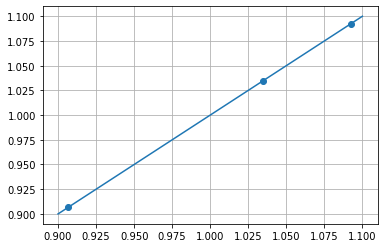

In [123]:
plt.scatter(res_1['data']['x_opt'], res_2['data']['x_opt'])
plt.plot([0.9, 1.1], [0.9, 1.1])
plt.grid()
plt.show()

In [228]:
azaza = pricing_optimization(data, PyomoNlpOptimizationModel, opt_params, 'ipopt')

In [231]:
azaza[0]['data'].head(10)

,plu_line_idx,P,Q,E,PC,C,plu_idx,x_lower,x_upper,x_init,x_opt,P_opt,Q_opt
0,0,62.99,2.569519,-1.490816,59.99,49.33,0,0.9,1.095229,0.997615,0.9,56.691,2.982615
1,1,106.99,2.209918,-0.257728,107.99,81.54,1,0.9,1.100000,1.000000,1.1,117.689,2.153690
2,2,88.99,0.883612,-0.780544,88.99,71.66,2,0.9,1.100000,1.000000,1.1,97.889,0.817265
3,3,108.99,2.846985,-0.742681,106.99,90.75,3,0.9,1.100000,1.000000,1.1,119.889,2.643206
4,4,68.99,2.065722,-1.721726,68.99,56.25,4,0.9,1.100000,1.000000,0.9,62.091,2.453836
5,5,76.99,5.340366,-0.370492,75.99,73.02,5,0.9,1.100000,1.000000,1.1,84.689,5.146130
6,6,64.99,2.106033,-2.248605,59.99,48.64,6,0.9,1.061525,0.980762,0.9,58.491,2.637065
7,7,48.99,1.624171,-2.139312,43.99,45.30,7,0.9,1.032629,0.966315,0.9,44.091,2.011596
8,7,48.99,1.624171,-0.281378,43.99,45.30,8,0.9,1.032629,0.966315,0.9,44.091,1.670520
9,7,48.99,1.624171,-1.821074,43.99,45.30,9,0.9,1.032629,0.966315,0.9,44.091,1.948587
